# Chapter 2 - Simple Logistic Regression

Nice links: https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch

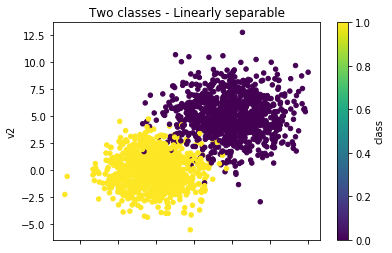

In [2]:
x1 = np.random.normal(loc=[5, 5], scale=2.0, size=[1000,2])
x1 = pd.DataFrame(x1, columns=['v1', 'v2'])
x1['class'] = 0

x2 = np.random.normal(loc=[0, 0], scale=1.5, size=[1000,2])
x2 = pd.DataFrame(x2, columns=['v1', 'v2'])
x2['class'] = 1

X = pd.concat([x1, x2], ignore_index=True)
X = X.sample(frac=1)
X.plot.scatter(x='v1',y='v2', c='class', colormap='viridis', title='Two classes - Linearly separable');

## Model, Loss and Optimiser

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-custom-nn-modules

In [3]:
class Perceptron(nn.Module):                 # we need to define forward function
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)   # linear activation: https://pytorch.org/docs/stable/nn.html#torch.nn.Linear
    
    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in)).squeeze()
    

## Running optimisation

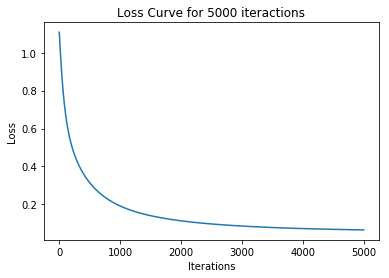

In [4]:
X_torch = torch.from_numpy(X.drop('class', axis=1).values).double()
y_torch = torch.from_numpy(X['class'].values).double()

input_dim = X_torch.shape[1]
lr = 2e-3

perceptron = Perceptron(input_dim = input_dim).double()      # model
bce_loss = nn.BCELoss()                                      # loss - binary cross entropy for binary classification
optimiser = optim.Adam(params=perceptron.parameters(), lr=lr)

### Run optimisation
N_EPOCHS=5000

loss_curve = []
for i in range(N_EPOCHS):

    perceptron.zero_grad()

    y_pred = perceptron(X_torch)

    loss = bce_loss(y_pred, y_torch)
    loss_curve.append(loss)

    loss.backward()

    optimiser.step()

plt.plot(loss_curve) 
plt.title(f'Loss Curve for {N_EPOCHS} iteractions')
plt.ylabel('Loss')
plt.xlabel('Iterations');

## Finding the straight line

TODO: matplotlib animation?

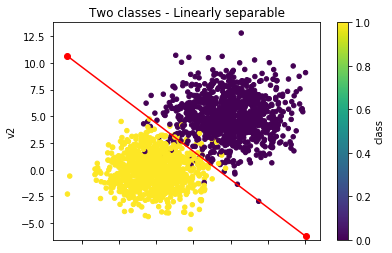

In [5]:
betas = list(perceptron.parameters())[0].data.squeeze().numpy()
bias = list(perceptron.parameters())[1].data.squeeze().numpy()

def get_line_function(betas, bias):
    # decision boundary: 0 = b + w1*x1 + w2*x2
    # when x1 = 0 --> w2*x2 = -b --> x2 = -b/w2
    # when x2 = 0 --> w1*x1 = -b --> x1 = -b/w1

    p1_decision_boundary = [-bias/betas[0], 0]
    p2_decision_boundary = [0, -bias/betas[1]]

    # find line equation:
    a = (p2_decision_boundary[1] - p1_decision_boundary[1])/(p2_decision_boundary[0] - p1_decision_boundary[0])
    b = -a*p1_decision_boundary[0]
    x = np.arange(-5, 11, 1)
    line = lambda x: a*x + b
    
    return line

line = get_line_function(betas, bias)
point1 = X['v1'].min()
point1 = [point1, line(point1)]
point2 = X['v1'].max()
point2 = [point2, line(point2)]

X.plot.scatter(x='v1',y='v2', c='class', colormap='viridis', title='Two classes - Linearly separable')
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'ro-')
plt.ylim(X['v2'].min()-1, X['v2'].max()+1)
plt.xlim(X['v1'].min()-1, X['v1'].max()+1);

# XOR Problem and Multilayer Perceptron

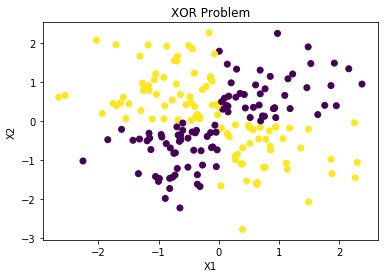

In [6]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(X[:,0], X[:,1], c=y)
plt.title('XOR Problem')
plt.xlabel('X1')
plt.ylabel('X2');

In [7]:
class NN(nn.Module):
    def __init__(self, input_dim, size_fc1):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, size_fc1)
        self.relu = torch.nn.ReLU()
        self.fc2 = nn.Linear(size_fc1, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        out_fc1 = self.relu(self.fc1(x))
        out_fc2 = self.sigmoid(self.fc2(out_fc1)).squeeze()
        return out_fc2
        

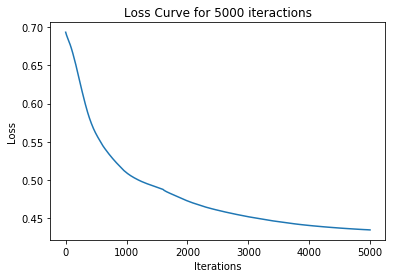

In [8]:
X_torch = torch.from_numpy(X).double()
y_torch = torch.from_numpy(y).double()

n_net = NN(X.shape[1], 2).double()
bce_loss = torch.nn.BCELoss()
lr = 2e-3
optimiser = optim.Adam(params=n_net.parameters(), lr=lr) # https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
loss_curve = []

for i in range(N_EPOCHS):
    
    n_net.zero_grad()
    
    pred = n_net(X_torch)
    
    loss = bce_loss(pred, y_torch)
    loss_curve.append(loss)
    loss.backward()
    
    optimiser.step()
    
plt.plot(loss_curve)
plt.title(f'Loss Curve for {N_EPOCHS} iteractions')
plt.ylabel('Loss')
plt.xlabel('Iterations');   

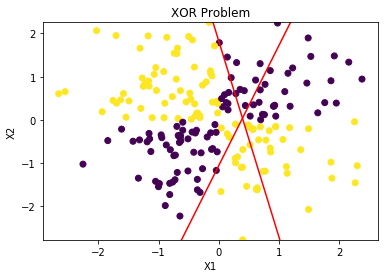

In [9]:
params = list(n_net.fc1.parameters())
betas_p1 = params[0].data[0].numpy()
betas_p2 = params[0].data[1].numpy()
bias = params[1].data[0].numpy()

line1 = get_line_function(betas_p1, bias)
point1_1 = X[:,0].min()
point1_1 = [point1_1, line1(point1_1)]
point1_2 = X[:,0].max()
point1_2 = [point1_2, line1(point1_2)]

line2 = get_line_function(betas_p2, bias)
point2_1 = X[:,0].min()
point2_1 = [point2_1, line2(point2_1)]
point2_2 = X[:,0].max()
point2_2 = [point2_2, line2(point2_2)]

plt.scatter(X[:,0], X[:,1], c=y)
plt.plot([point1_1[0], point1_2[0]], [point1_1[1], point1_2[1]], 'ro-')
plt.plot([point2_1[0], point2_2[0]], [point2_1[1], point2_2[1]], 'ro-')
plt.ylim([X[:,1].min(), X[:,1].max()])
plt.title('XOR Problem')
plt.xlabel('X1')
plt.ylabel('X2');